# Problem Statement

Recent visitors do say, you should brace yourself for the high cost of meals at multiple restaurants In order to resolve this issue, the amenities can be remodeled with new menu and choices based on the economical condition of the customer. As the resorts cover a wide area only rich people go in depths of the resorts who buy the shuttle services, customers with low budget only explore the outer parts of the resorts. The task is to identify economic class of the customer based on the data collected so that the board can resolve this with proper remodeling. 

In [1]:
!wget https://www.dropbox.com/s/meflbukhp33tbj2/plastics_type.csv -nv
!wget https://www.dropbox.com/s/rtkd1f4iulf8jp0/auto-mpg.csv -nv
!wget https://www.dropbox.com/s/oqsri5a5a85tlaa/guest_data.csv -nv

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.metrics import classification_report,f1_score
from sklearn.naive_bayes import BernoulliNB

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('guest_data.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
cols=['Age','Work_type','Final_weight','Education','School_education','Marital_st','Occupation','Relationship','Race','Sex','Capital_gain','Capital_loss','HPW','Native_Country','Target']
df.columns=cols
df.columns

Index(['Age', 'Work_type', 'Final_weight', 'Education', 'School_education',
       'Marital_st', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'HPW', 'Native_Country', 'Target'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               48842 non-null  int64 
 1   Work_type         46043 non-null  object
 2   Final_weight      48842 non-null  int64 
 3   Education         48842 non-null  object
 4   School_education  48842 non-null  int64 
 5   Marital_st        48842 non-null  object
 6   Occupation        46033 non-null  object
 7   Relationship      48842 non-null  object
 8   Race              48842 non-null  object
 9   Sex               48842 non-null  object
 10  Capital_gain      48842 non-null  int64 
 11  Capital_loss      48842 non-null  int64 
 12  HPW               48842 non-null  int64 
 13  Native_Country    47985 non-null  object
 14  Target            48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


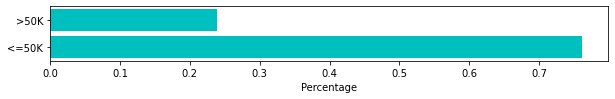

In [6]:
#check if the data is balanced or not so that incase the data is imbalanced
# we can perform imputation for balancing

def data_distibution(data,col):
    vc=data[col].value_counts()
    data_ratio=pd.DataFrame({'Counts':vc,
                            'Percentage': vc/len(data)})
    plt.figure(figsize=(10,1))
    plt.barh(data_ratio.index,data_ratio['Percentage'],color='c')
    plt.xlabel('Percentage')
    plt.show()

data_distibution(df,'Target')

In [7]:
print('Null values in each columns (if any):')
print(df.isnull().sum())
print('\n\nTotal null values in the whole dataset: ',sum(df.isnull().sum()))

Null values in each columns (if any):
Age                    0
Work_type           2799
Final_weight           0
Education              0
School_education       0
Marital_st             0
Occupation          2809
Relationship           0
Race                   0
Sex                    0
Capital_gain           0
Capital_loss           0
HPW                    0
Native_Country       857
Target                 0
dtype: int64


Total null values in the whole dataset:  6465


In [8]:
print('Null values in percenatges:')
print(df.isnull().sum()/len(df))

Null values in percenatges:
Age                 0.000000
Work_type           0.057307
Final_weight        0.000000
Education           0.000000
School_education    0.000000
Marital_st          0.000000
Occupation          0.057512
Relationship        0.000000
Race                0.000000
Sex                 0.000000
Capital_gain        0.000000
Capital_loss        0.000000
HPW                 0.000000
Native_Country      0.017546
Target              0.000000
dtype: float64


In [9]:
na_cols=[]
for i in df.columns:
     if df[i].isna().sum()>0:
        na_cols.append(i)

na_cols



['Work_type', 'Occupation', 'Native_Country']

In [10]:
for i in na_cols:
    df[i]=df[i].fillna(df[i].mode()[0])

df.isna().sum()

Age                 0
Work_type           0
Final_weight        0
Education           0
School_education    0
Marital_st          0
Occupation          0
Relationship        0
Race                0
Sex                 0
Capital_gain        0
Capital_loss        0
HPW                 0
Native_Country      0
Target              0
dtype: int64

In [11]:
#creating two datasets for trying both dummy variable and labelencoder

dummy_data=df.copy()
label_data=df.copy()

In [12]:
def findUnique(data):
    unique=0
    unique_data={'col_name':[],'unique_counts':[],'max_values':[],'min_values':[]}
    for i in data.columns:
        unique_data['col_name'].append(i)
        unique_data['unique_counts'].append(len(data[i].unique()))
        unique_data['max_values'].append(data[i].max())
        unique_data['min_values'].append(data[i].min())
        unique+=len(data[i].unique())

    return pd.DataFrame(unique_data),unique

u,ud=findUnique(dummy_data)
print(u.sort_values(by='unique_counts'))
print('Total unique valuess: ',ud)
print('Dataset shape : ',dummy_data.shape)


            col_name  unique_counts        max_values          min_values
9                Sex              2              Male              Female
14            Target              2              >50K               <=50K
8               Race              5             White  Amer-Indian-Eskimo
7       Relationship              6              Wife             Husband
5         Marital_st              7           Widowed            Divorced
1          Work_type              8       Without-pay         Federal-gov
6         Occupation             14  Transport-moving        Adm-clerical
3          Education             16      Some-college                10th
4   School_education             16                16                   1
13    Native_Country             41        Yugoslavia            Cambodia
0                Age             74                90                  17
12               HPW             96                99                   1
11      Capital_loss             99   

In [13]:
lb=LabelEncoder()

dummy_data.Age=lb.fit_transform(dummy_data.Age)
dummy_data.Education=lb.fit_transform(dummy_data.Education)
dummy_data.HPW=lb.fit_transform(dummy_data.HPW)


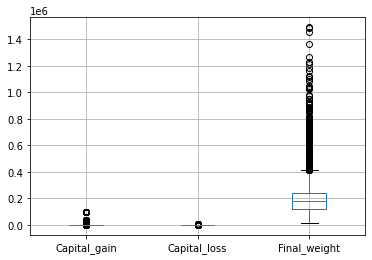

In [14]:
dummy_data.boxplot(column=['Capital_gain','Capital_loss','Final_weight'])
plt.show()

In [15]:
scale=MinMaxScaler()

dummy_data.Capital_gain=scale.fit_transform(np.array(dummy_data.Capital_gain.values.astype(float)).reshape(1,-1))[0]
dummy_data.Capital_loss=scale.fit_transform(np.array(dummy_data.Capital_loss.values.astype(float)).reshape(1,-1))[0]
dummy_data.Final_weight=scale.fit_transform(np.array(dummy_data.Final_weight.values.astype(float)).reshape(1,-1))[0]


In [16]:
dols=['Work_type','School_education','Marital_st','Occupation','Relationship','Race','Sex','Native_Country']
dummy_data=pd.get_dummies(dummy_data,columns=dols)
dummy_data.head()

,Age,Final_weight,Education,Capital_gain,Capital_loss,HPW,Target,Work_type_Federal-gov,Work_type_Local-gov,Work_type_Never-worked,...,Native_Country_Portugal,Native_Country_Puerto-Rico,Native_Country_Scotland,Native_Country_South,Native_Country_Taiwan,Native_Country_Thailand,Native_Country_Trinadad&Tobago,Native_Country_United-States,Native_Country_Vietnam,Native_Country_Yugoslavia
0,8,0.0,1,0.0,0.0,39,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,21,0.0,11,0.0,0.0,49,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,11,0.0,7,0.0,0.0,39,>50K,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,27,0.0,15,0.0,0.0,39,>50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0.0,15,0.0,0.0,29,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
dummy_data.Target=lb.fit_transform(dummy_data.Target)
dummy_data.head()

,Age,Final_weight,Education,Capital_gain,Capital_loss,HPW,Target,Work_type_Federal-gov,Work_type_Local-gov,Work_type_Never-worked,...,Native_Country_Portugal,Native_Country_Puerto-Rico,Native_Country_Scotland,Native_Country_South,Native_Country_Taiwan,Native_Country_Thailand,Native_Country_Trinadad&Tobago,Native_Country_United-States,Native_Country_Vietnam,Native_Country_Yugoslavia
0,8,0.0,1,0.0,0.0,39,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,21,0.0,11,0.0,0.0,49,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,11,0.0,7,0.0,0.0,39,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,27,0.0,15,0.0,0.0,39,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0.0,15,0.0,0.0,29,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
label_data=label_data.apply(lambda x: lb.fit_transform(x))

In [19]:
label_data.head()

,Age,Work_type,Final_weight,Education,School_education,Marital_st,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,HPW,Native_Country,Target
0,8,3,19329,1,6,4,6,3,2,1,0,0,39,38,0
1,21,3,4212,11,8,2,4,0,4,1,0,0,49,38,0
2,11,1,25340,7,11,2,10,0,4,1,0,0,39,38,1
3,27,3,11201,15,9,2,6,0,2,1,98,0,39,38,1
4,1,3,5411,15,9,4,9,3,4,0,0,0,29,38,0


In [20]:
#split datasets to train and test

X=dummy_data.drop('Target',axis=1)
Y=dummy_data.Target

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=13)


In [21]:
d_gnb=GaussianNB()
d_gnb.fit(X_train,Y_train)
dummy_pred=d_gnb.predict(X_test)

In [22]:
#split datasets to train and test

P=label_data.drop('Target',axis=1)
Q=label_data.Target

P_train,P_test,Q_train,Q_test=train_test_split(P,Q,test_size=0.3,random_state=13)


In [23]:
l_gnb=GaussianNB()
l_gnb.fit(P_train,Q_train)
label_pred=l_gnb.predict(P_test)

In [24]:
print('The accuracy of the Gaussian dummy model is: ',round(accuracy_score(Y_test,dummy_pred)*100,2))
print('The accuracy of the Gaussian label model is: ',round(accuracy_score(Q_test,label_pred)*100,2))

The accuracy of the Gaussian dummy model is:  62.41
The accuracy of the Gaussian label model is:  81.09


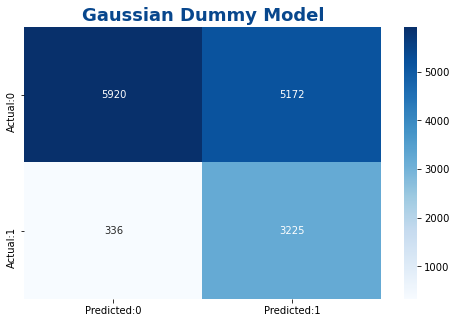

In [27]:
dcm=confusion_matrix(Y_test,dummy_pred)
dconf_matrix=pd.DataFrame(data=dcm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(dconf_matrix,annot=True,fmt='d',cmap='Blues')
fm={'size':18,'color':'#08478d','weight':'bold'}
plt.title('Gaussian Dummy Model',**fm)
plt.show()

In [29]:
TN=dcm[0,0]
TP=dcm[1,1]
FN=dcm[1,0]
FP=dcm[0,1]

sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

print('True Negative:',TN)
print('True Positive:',TP)
print('False Negative:',FN)
print('False Postive:',FP)

print('Sensitivity:',sensitivity)
print('Specificity:',specificity)


True Negative: 5920
True Positive: 3225
False Negative: 336
False Postive: 5172
Sensitivity: 0.9056444818871103
Specificity: 0.5337179949513162


The model is more sensitive than specific means it predicts target >50K more accurately

In [30]:
#calculate precision and recall values

def initialize_evaluator():
    return {'Model':[],'Accuracy':[],'Precision':[],'Recall':[],'F1_score':[]}

def insert_data(test,pred,model):
    eval_data=initialize_evaluator()
    eval_data['Model'].append(model)
    eval_data['Accuracy'].append(accuracy_score(test,pred))
    eval_data['Precision'].append(precision_score(test,pred))
    eval_data['Recall'].append(recall_score(test,pred))
    eval_data['F1_score'].append(f1_score(test,pred))
    return eval_data

def append_data(data1,data2):
    for i in data1.keys():
        data2[i].extend(data1[i])
    return data2


In [31]:
dummy_eval_data=insert_data(Y_test,dummy_pred,'Gaussian Dummy Model')
pd.DataFrame(dummy_eval_data)

,Model,Accuracy,Precision,Recall,F1_score
0,Gaussian Dummy Model,0.624104,0.384066,0.905644,0.539388


From above we can say that our model is able to correctly classify around 91% guests with >=50k

In [32]:
#classification report
print(classification_report(Y_test,dummy_pred))

              precision    recall  f1-score   support

           0       0.95      0.53      0.68     11092
           1       0.38      0.91      0.54      3561

    accuracy                           0.62     14653
   macro avg       0.67      0.72      0.61     14653
weighted avg       0.81      0.62      0.65     14653



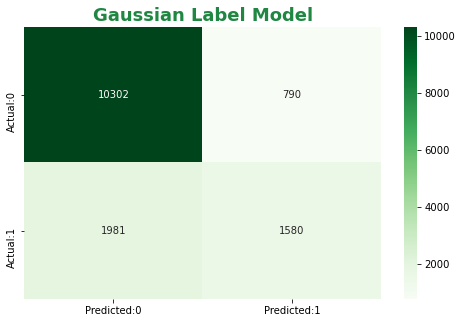

In [34]:
#for gaussain label model

lcm=confusion_matrix(Q_test,label_pred)
lconf_matrix=pd.DataFrame(data=lcm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(lconf_matrix,annot=True,fmt='d',cmap='Greens')
fm={'size':18,'color':'#1f8742','weight':'bold'}
plt.title('Gaussian Label Model',**fm)
plt.show()

In [35]:
TN=lcm[0,0]
TP=lcm[1,1]
FN=lcm[1,0]
FP=lcm[0,1]

sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

print('True Negative:',TN)
print('True Positive:',TP)
print('False Negative:',FN)
print('False Postive:',FP)

print('Sensitivity:',sensitivity)
print('Specificity:',specificity)


True Negative: 10302
True Positive: 1580
False Negative: 1981
False Postive: 790
Sensitivity: 0.4436955911260882
Specificity: 0.928777497295348


The model is more specific than sensitive meaning it predicts target <50k more accurately

In [36]:
label_eval_data=insert_data(Q_test,label_pred,'Gaussian Label Model')
pd.DataFrame(label_eval_data)

,Model,Accuracy,Precision,Recall,F1_score
0,Gaussian Label Model,0.810892,0.666667,0.443696,0.532794


In [37]:
#classification report
print(classification_report(Q_test,label_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     11092
           1       0.67      0.44      0.53      3561

    accuracy                           0.81     14653
   macro avg       0.75      0.69      0.71     14653
weighted avg       0.80      0.81      0.80     14653



In [46]:
eval_data=append_data(label_eval_data,dummy_eval_data)

Let's trying applying Bernoulli Naive Bayes

In [39]:
bnb=BernoulliNB(alpha=2)

#for dummy data

bnb.fit(X_train,Y_train)
dummy_pred=bnb.predict(X_test)
print('The accuracy for bernoulli dummy model is:',round(accuracy_score(Y_test,dummy_pred)*100,2))

#for label data

bnb.fit(P_train,Q_train)
label_pred=bnb.predict(P_test)
print('The accuracy for bernoulli label model is:',round(accuracy_score(Q_test,label_pred)*100,2))

The accuracy for bernoulli dummy model is: 75.23
The accuracy for bernoulli label model is: 73.08


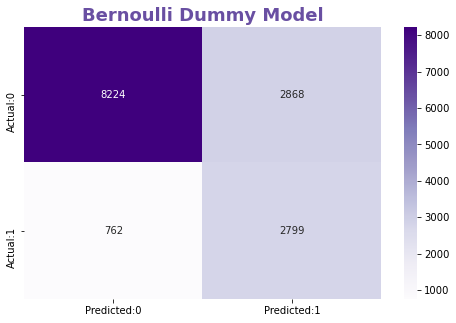

In [41]:
#dummy data
dcm=confusion_matrix(Y_test,dummy_pred)
dconf_matrix=pd.DataFrame(data=dcm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(dconf_matrix,annot=True,fmt='d',cmap='Purples')
fm={'size':18,'color':'#694fa2','weight':'bold'}
plt.title('Bernoulli Dummy Model',**fm)
plt.show()

In [42]:
TN=dcm[0,0]
TP=dcm[1,1]
FN=dcm[1,0]
FP=dcm[0,1]

sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

print('True Negative:',TN)
print('True Positive:',TP)
print('False Negative:',FN)
print('False Postive:',FP)

print('Sensitivity:',sensitivity)
print('Specificity:',specificity)

True Negative: 8224
True Positive: 2799
False Negative: 762
False Postive: 2868
Sensitivity: 0.7860151642796968
Specificity: 0.7414352686620989


In [48]:
bern_dummy_data=insert_data(Y_test,dummy_pred,'Bernoulli Dummy Model')
pd.DataFrame(bern_dummy_data)

,Model,Accuracy,Precision,Recall,F1_score
0,Bernoulli Dummy Model,0.752269,0.493912,0.786015,0.606632


In [43]:
print(classification_report(Y_test,dummy_pred))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82     11092
           1       0.49      0.79      0.61      3561

    accuracy                           0.75     14653
   macro avg       0.70      0.76      0.71     14653
weighted avg       0.81      0.75      0.77     14653



In [50]:
eval_data=append_data(bern_dummy_data,eval_data)

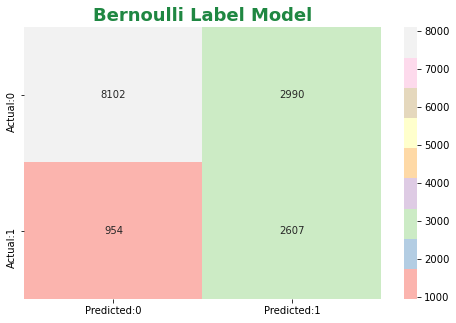

In [44]:
#for label data

lcm=confusion_matrix(Q_test,label_pred)
lconf_matrix=pd.DataFrame(data=lcm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(lconf_matrix,annot=True,fmt='d',cmap='Pastel1')
fm={'size':18,'color':'#1f8742','weight':'bold'}
plt.title('Bernoulli Label Model',**fm)
plt.show()

In [45]:
TN=lcm[0,0]
TP=lcm[1,1]
FN=lcm[1,0]
FP=lcm[0,1]

sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

print('True Negative:',TN)
print('True Positive:',TP)
print('False Negative:',FN)
print('False Postive:',FP)

print('Sensitivity:',sensitivity)
print('Specificity:',specificity)

True Negative: 8102
True Positive: 2607
False Negative: 954
False Postive: 2990
Sensitivity: 0.7320977253580455
Specificity: 0.7304363505228993


The model is both specific and senstive

In [49]:
bern_label_model=insert_data(Q_test,label_pred,'Bernoulli Label Model')
pd.DataFrame(bern_label_model)

,Model,Accuracy,Precision,Recall,F1_score
0,Bernoulli Label Model,0.73084,0.465785,0.732098,0.569338


In [51]:
eval_data=append_data(bern_label_model,eval_data)

In [52]:
pd.DataFrame(eval_data)

,Model,Accuracy,Precision,Recall,F1_score
0,Gaussian Dummy Model,0.624104,0.384066,0.905644,0.539388
1,Gaussian Label Model,0.810892,0.666667,0.443696,0.532794
2,Bernoulli Dummy Model,0.752269,0.493912,0.786015,0.606632
3,Bernoulli Label Model,0.730840,0.465785,0.732098,0.569338


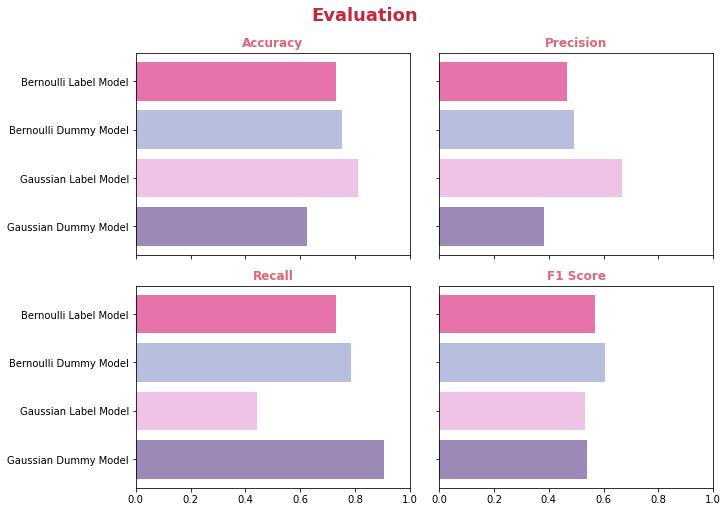

In [54]:
def plot_models(data):
    sns.set_palette(sns.color_palette("rocket"))
    super_title={'size':18,'color':'#c5283d','weight':'bold'}
    sub_title={'size':12,'color':'#e06777','weight':'bold'}
    colors=np.array([[156,137,184],[239,195,230],[184,190,221],[231,115,171]])
    colors=colors/255
    data=pd.DataFrame(data)
    fig=plt.figure(figsize=(10,7),constrained_layout=True)
    gs=GridSpec(2,2,figure=fig)
    ax1=fig.add_subplot(gs[0,0])
    ax1.barh(data.Model,data.Accuracy,color=colors)
    ax1.tick_params(labelbottom=False,labelleft=True)
    ax1.set_xlim(0,1)
    ax1.set_title('Accuracy',**sub_title)
    ax2=fig.add_subplot(gs[0,1])
    ax2.barh(data.Model,data.Precision,color=colors)
    ax2.tick_params(labelbottom=False,labelleft=False)
    ax2.set_xlim(0,1)
    ax2.set_title('Precision',**sub_title)
    ax3=fig.add_subplot(gs[1,0])
    ax3.barh(data.Model,data.Recall,color=colors)
    ax3.tick_params(labelbottom=True,labelleft=True)
    ax3.set_xlim(0,1)
    ax3.set_title('Recall',**sub_title)
    ax4=fig.add_subplot(gs[1,1])
    ax4.barh(data.Model,data.F1_score,color=colors)
    ax4.tick_params(labelbottom=False,labelleft=False)
    ax4.set_xlim(0,1)
    ax4.set_title('F1 Score',**sub_title)
    fig.suptitle('Evaluation',**super_title)
    ax4.tick_params(labelbottom=True,labelleft=False)
    plt.show()

plot_models(eval_data)


From the above we can determine the best model. Overall gaussian dummy model has best recall but accuracy is pretty low as well as precision score. Even Gaussian label has best accuracy but the truth is that the model is performing really bad as recall is worst. On an average sense, we can see that our Bernoulli model is performing well enough to be selected.

# Conclusion
Even though dummy Bernoulli model produced better accuracy it would not be appreciated if it used as it has highly specific. As Bernoulli label model has a good accuracy of 73.1%, it would be best if it is used. Bernoulli model is best used when we have independent features and have a binary outcome.